### Análise do ano de 2022

Utilizando como base o trabalho descrito em "https://sol.sbc.org.br/index.php/bwaif/article/view/24959", este notebook desenvolverá um alocador de portfólio baseado em aprendizado por reforço, sendo sua performance avaliada ao longo do ano de 2022.

In [1]:
# Importação do diretório atual de trabalho
import sys
upper_path = sys.path[0][:-8]
sys.path.append(upper_path)

# Importação d0 módulo responsável por criar o banco de dados personalizado
from quantamental_lib import RLDatabase

# Importação de bibliotecas auxiliares
import pandas as pd
import torch

In [2]:
# Criação dos bancos de dados. Os dados de treino e teste são igualmente distribuídos com base na quantidade máxima de ativos selecionada (30).
rl_db = RLDatabase(end_train = '2021-12-31',end_test='2022-12-31', test_time_window=50)

# Leitura ou criação dos DataFrames de treino e teste
try:
    train_df = pd.read_csv('train_test_dfs/train_2022.csv')
except:
    train_df = rl_db.create_train_database()
    train_df.to_csv('train_test_dfs/train_2022.csv', index=False)

try:
    test_df = pd.read_csv('train_test_dfs/test_2022.csv')
except:
    test_df = rl_db.create_test_database()
    test_df.to_csv('train_test_dfs/test_2022.csv', index=False)

# Universo de tickers disponíveis
br_tickers = train_df.tic.unique()

print(br_tickers)

['ABEV3' 'AMAR3' 'B3SA3' 'BBAS3' 'BBDC3' 'BBDC4' 'BHIA3' 'BRAP4' 'CCRO3'
 'CIEL3' 'CMIG4' 'COGN3' 'CPLE6' 'CSNA3' 'CVCB3' 'EMBR3' 'FNOR11' 'GGBR4'
 'GOAU4' 'ITSA4' 'ITUB4' 'JBSS3' 'LREN3' 'MGLU3' 'PETR3' 'PETR4' 'PRIO3'
 'RENT3' 'USIM5' 'VALE3']


### Treino do modelo

O ambiente será treinado ao longo de 100 episódios, sendo sua taxa de aprendizado igual a 0.001.

In [3]:
# Importação do módulo contendo as principais classes necessárias para o treinamento
from quantamental_lib.finRL_POE import *

# Definição das features que serão avaliados pelo modelo
features = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'mom', 'cci', 'stoch',
       'williams', 'macd', 'macd_signal', 'bband', 'USD/BRL', 'IBOV', 'SPX',
       'DJI', 'CDI', 'NASDAQ', 'IPCA', 'SELIC', 'IGPM', 'day']

# Ambiente de Treino
environment = PortfolioOptimizationEnv(
        train_df,
        initial_amount=100000,
        comission_fee_pct=0,
        time_window=50,
        features=features
    )

# Treinamento do modelo
algo = PG(environment, lr=0.001, portfolio_size = len(br_tickers))
algo.train(episodes=100)

# Salvando o modelo treinado
torch.save(algo.target_policy.state_dict(), "trained_models/policy_EIIE_2022.pt")

  0%|          | 0/100 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 458314.59375
Final accumulative portfolio value: 4.5831459375
Maximum DrawDown: -0.5242659537822727
Sharpe ratio: 0.8803130804334615
Initial portfolio value:100000
Final portfolio value: 479685.4375
Final accumulative portfolio value: 4.796854375
Maximum DrawDown: -0.5233725559458489
Sharpe ratio: 0.9019869790276821
Initial portfolio value:100000
Final portfolio value: 496255.3125
Final accumulative portfolio value: 4.962553125
Maximum DrawDown: -0.522095104801416
Sharpe ratio: 0.9182656054580051
Initial portfolio value:100000
Final portfolio value: 516482.34375
Final accumulative portfolio value: 5.1648234375
Maximum DrawDown: -0.5209615921597267
Sharpe ratio: 0.9369821667685007
Initial portfolio value:100000
Final portfolio value: 541120.75
Final accumulative portfolio value: 5.4112075
Maximum DrawDown: -0.5197552163935817
Sharpe ratio: 0.958762842311125
Initial portfolio value:100000
Final portfolio value: 575180.125
Final accumu

## Teste do modelo

Após o treinamento, será criado um novo ambiente de teste utilizado para a avaliação de sua performance no ano de 2022.

In [3]:
# Ambiente de teste
environment_test = PortfolioOptimizationEnv(
        test_df,
        initial_amount=100000,
        comission_fee_pct=0,
        time_window=50,
        features=features
    )

# Importação e preparação do modelo treinado
policy = GradientPolicy()
policy.load_state_dict(torch.load("trained_models/policy_EIIE_2022.pt"))
policy = policy.to(device)

# Obtenção das métricas ao longo de 2022
done = False
obs = environment_test.reset()
pvm = PVM(environment_test.episode_length, portfolio_size=len(br_tickers))
while not done:
    last_action = pvm.retrieve()
    obs_batch = np.expand_dims(obs, axis=0)
    last_action_batch = np.expand_dims(last_action, axis=0)
    action = policy(obs_batch, last_action_batch)
    pvm.add(action)
    obs, _, done, _ = environment_test.step(action)


Initial portfolio value:100000
Final portfolio value: 135431.78125
Final accumulative portfolio value: 1.3543178125
Maximum DrawDown: -0.26693322071325787
Sharpe ratio: 1.0009275999027776


## Avaliação dos resultados

Realização de uma análise da performance ao longo de 2022.

In [4]:
# Importação do módulo responsável por avaliar a performance doo modelo ao longo de seu teste
from quantamental_lib import Backtest

bk = Backtest(test_environment= environment_test, portfolio_vector = pvm)

In [5]:
# Criação de um DataFrame contendo os retornos da estratégia e dos principais benchmarks (CDI e IBOV)
df = bk.general_cumulative_daily_returns()

# Salva o DataFrame em um arquivo CSV
df.to_csv('results_df/results_2022.csv', index=True)

display(df)

,Cumulative Daily Returns,IBOV,CDI
2022-01-03,1.000000,1.000000,1.000347
2022-01-04,0.968057,0.996074,1.000695
2022-01-05,0.963415,0.971940,1.001043
2022-01-06,0.942842,0.977281,1.001391
2022-01-07,0.987932,0.988424,1.001739
...,...,...,...
2022-12-22,1.391901,1.032669,1.120491
2022-12-23,1.426265,1.055580,1.121060
2022-12-27,1.420160,1.042580,1.122199
2022-12-28,1.445606,1.060767,1.122769


In [6]:
# Avaliação do índice de Sharpe do modelo
sharpe_ratio = bk.sharpe_ratio(risk_free_rate=0)

print('Sharpe Ratio: ', sharpe_ratio)

Sharpe Ratio:  1.1947932426715417


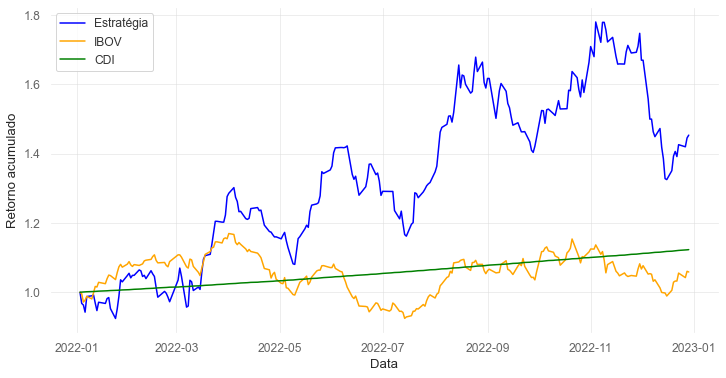

In [7]:
# Plotagem dos resultados para facilitar sua comparação
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6)) 

plt.plot(df['Cumulative Daily Returns'], label='Estratégia', color ='blue')  
plt.plot(df['IBOV'], label='IBOV', color ='orange')  
plt.plot(df['CDI'], label='CDI', color ='green')  

plt.legend()

plt.ylabel('Retorno acumulado')
plt.xlabel('Data')

plt.show()